<a href="https://colab.research.google.com/github/denniss83/YouTube-T-rkiye-Trend-Analizi-Kategori-Etkile-im-ve-zlenme-Dinamikleri-Haziran-2024-/blob/main/YouTube_T%C3%BCrkiye_Trend_Analizi_%E2%80%93_Kategori%2C_Etkile%C5%9Fim_ve_%C4%B0zlenme_Dinamikleri_(Haziran_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 YouTube Türkiye Trend Video Analizi (2024)

🔍 Bu çalışmada, YouTube Data API v3 kullanılarak Türkiye'de trend (popüler) olan videolar analiz edilmiştir.  
İzlenme, beğeni, yorum ve içerik kategorilerine göre çeşitli analizler ve görselleştirmeler yapılmıştır.

⚠️ **Not:** **Bu çalışma tamamen python ile veri analizi kapsamında eğitim ve öğrenme amaçlı hazırlanmıştır. Ticari bir kullanım hedeflenmemektedir.**


In [29]:
!pip install --upgrade google-api-python-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 95.4 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.173.0
    Uninstalling google-api-python-client-2.173.0:
      Successfully uninstalled google-api-python-client-2.173.0


In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
from googleapiclient.discovery import build
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## 📥 YouTube API ile Türkiye Trend Verilerini Çekme

Bu bölümde `googleapiclient.discovery` kütüphanesi kullanılarak Türkiye'de trend olan YouTube videoları çekilmektedir.  
Toplamda 200 videoya ait başlık, kanal adı, kategori ID'si, izlenme, beğeni ve yorum sayıları elde edilmiştir.

In [31]:
from googleapiclient.discovery import build
import pandas as pd
from datetime import datetime
api_key = "***************************************"
youtube = build("youtube", "v3", developerKey=api_key)

videos = []
next_page_token = None

for _ in range(4):
    request = youtube.videos().list(
        part="snippet,statistics",
        chart="mostPopular",
        regionCode="TR",
        maxResults=50,
        pageToken=next_page_token
    )
    response = request.execute()

    for item in response["items"]:
        videos.append({
            "title": item["snippet"]["title"],
            "channel": item["snippet"]["channelTitle"],
            "category_id": item["snippet"]["categoryId"],
            "views": int(item["statistics"].get("viewCount", 0)),
            "likes": int(item["statistics"].get("likeCount", 0)),
            "comments": int(item["statistics"].get("commentCount", 0)),
            "published_at": item["snippet"]["publishedAt"]
        })

    next_page_token = response.get("nextPageToken")
    if not next_page_token:
        break

df_videos = pd.DataFrame(videos)
df_videos["published_at"] = pd.to_datetime(df_videos["published_at"])
df_videos.head()

,title,channel,category_id,views,likes,comments,published_at
0,$500 Water vs $1 Water – Blind Taste Test!,The Richey Family,22,24223902,501229,451,2025-06-27 15:02:00+00:00
1,Which Shoes Will Protect Your Feet?,Ben Azelart,24,82799295,2089067,7555,2025-06-24 21:50:02+00:00
2,Ben Bir Garip Keloğlanım... #çgh2 #bkm #komedi...,Çok Güzel Hareketler,23,1081917,27170,270,2025-06-27 16:30:05+00:00
3,"If You Spill, You Lose!",MrBeast,24,74126693,1830445,4615,2025-06-25 17:00:08+00:00
4,Benden Sonra - (Akustik) Zeynep Bastık & Rıza ...,Zeynep Bastık,10,4196485,92090,2605,2025-06-24 15:00:52+00:00


In [32]:
category_url = 'https://www.googleapis.com/youtube/v3/videoCategories'
params = {
    'part': 'snippet',
    'regionCode': 'TR',
    'key': api_key
}

response = requests.get(category_url, params=params)
categories_data = response.json()

category_mapping = {}
for item in categories_data['items']:
    category_mapping[item['id']] = item['snippet']['title']


In [33]:
df_videos['category_name'] = df_videos['category_id'].astype(str).map(category_mapping)
df_videos[['title', 'channel', 'category_name', 'views', 'likes', 'comments', 'published_at']].head()

,title,channel,category_name,views,likes,comments,published_at
0,$500 Water vs $1 Water – Blind Taste Test!,The Richey Family,People & Blogs,24223902,501229,451,2025-06-27 15:02:00+00:00
1,Which Shoes Will Protect Your Feet?,Ben Azelart,Entertainment,82799295,2089067,7555,2025-06-24 21:50:02+00:00
2,Ben Bir Garip Keloğlanım... #çgh2 #bkm #komedi...,Çok Güzel Hareketler,Comedy,1081917,27170,270,2025-06-27 16:30:05+00:00
3,"If You Spill, You Lose!",MrBeast,Entertainment,74126693,1830445,4615,2025-06-25 17:00:08+00:00
4,Benden Sonra - (Akustik) Zeynep Bastık & Rıza ...,Zeynep Bastık,Music,4196485,92090,2605,2025-06-24 15:00:52+00:00


## 📊 Trend Videoların Kategori Bazlı Dağılımı

Bu bölümde, YouTube API'den alınan kategori ID'leri anlamlı kategori isimlerine çevrilmiş ve trend videoların kategorilere göre dağılımı görselleştirilmiştir.


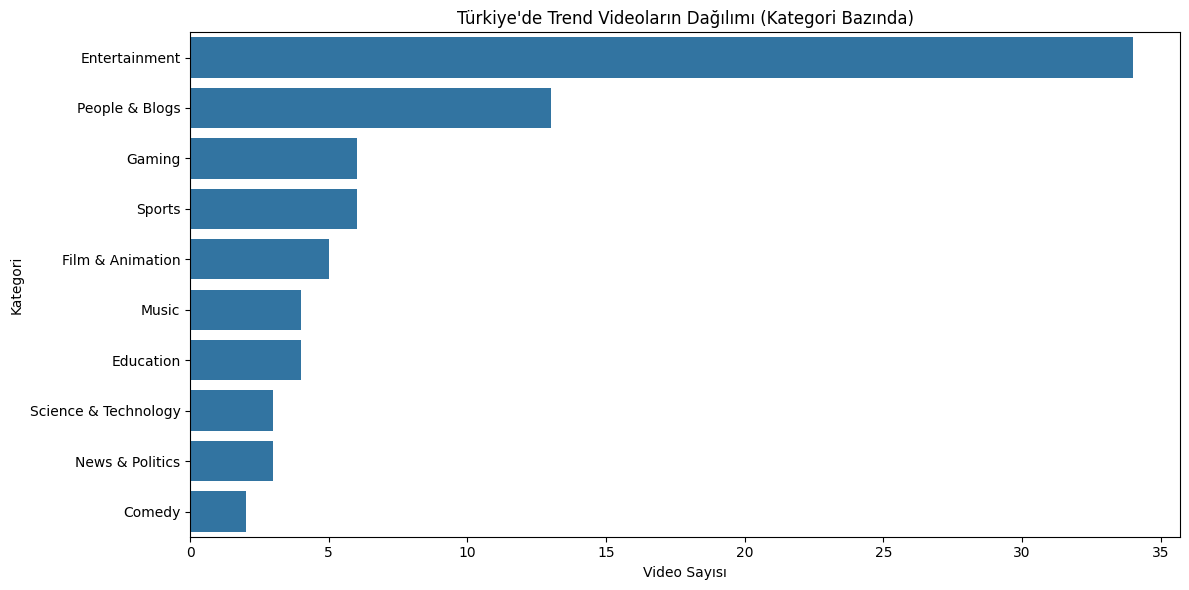

In [34]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_videos, y='category_name', order=df_videos['category_name'].value_counts().index)
plt.title("Türkiye'de Trend Videoların Dağılımı (Kategori Bazında)")
plt.xlabel("Video Sayısı")
plt.ylabel("Kategori")
plt.tight_layout()
plt.show()

## 📈 Kategori Bazında Ortalama İzlenme Sayısı Analizi

Bu bölümde, her kategori için videoların ortalama izlenme sayısı hesaplanmıştır.  
Elde edilen grafik, hangi içerik türlerinin izleyiciler tarafından daha fazla ilgi gördüğünü ortaya koymaktadır.  
Özellikle "Eğlence" ve "People & Blogs" kategorileri yüksek ortalamalarla öne çıkmaktadır.

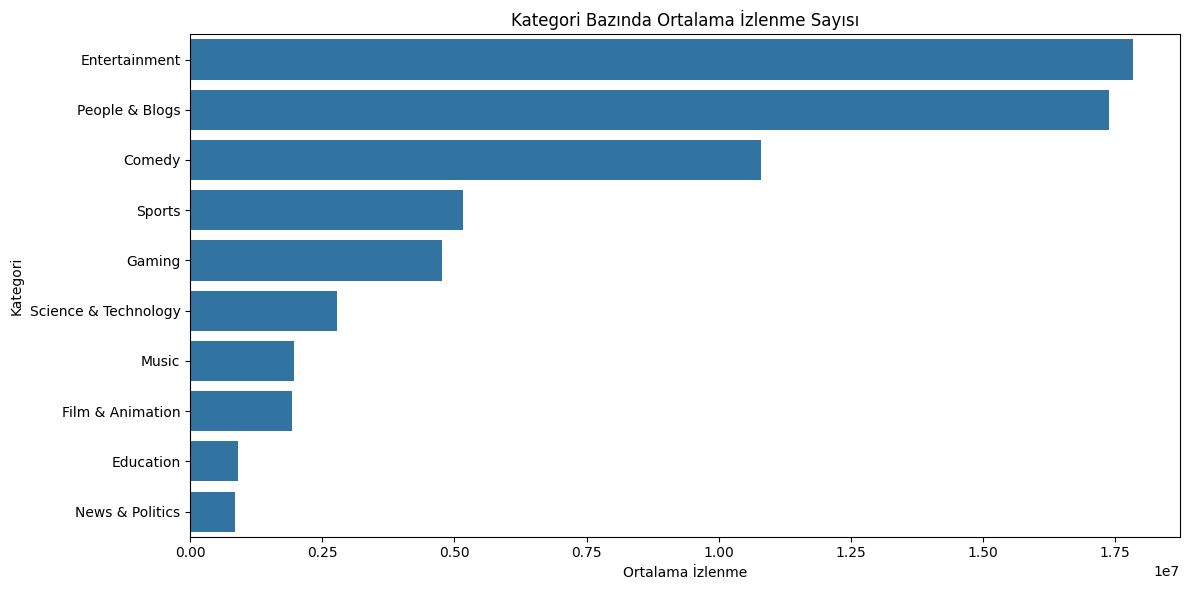

In [35]:
views_by_category = df_videos.groupby('category_name')['views'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=views_by_category.values, y=views_by_category.index)
plt.title("Kategori Bazında Ortalama İzlenme Sayısı")
plt.xlabel("Ortalama İzlenme")
plt.ylabel("Kategori")
plt.tight_layout()
plt.show()

## 👍 Kategori Bazında Ortalama Beğeni Oranı (likes/views)

Bu analizde, her video kategorisi için beğeni oranı (toplam beğeni / toplam izlenme) hesaplanmıştır.  
Yüksek beğeni oranı, izleyicilerin içerikten memnun kaldığını ve olumlu etkileşimde bulunduğunu gösterir.  
"Gaming" ve "News & Politics" gibi kategoriler bu metrikte öne çıkmaktadır.

In [48]:
df_videos.groupby("category_name")[["views", "likes", "comments"]].mean().sort_values("views", ascending=False)

,views,likes,comments
category_name,,,
Entertainment,1.783355e+07,486348.823529,5496.882353
People & Blogs,1.737279e+07,328334.076923,987.846154
Comedy,1.080570e+07,122201.500000,181.000000
Sports,5.165865e+06,84810.166667,553.333333
Gaming,4.766989e+06,296185.500000,6287.166667
Science & Technology,2.777254e+06,122287.333333,1045.333333
Music,1.956076e+06,64008.500000,6998.250000
Film & Animation,1.931280e+06,43997.800000,145.000000
Education,8.974945e+05,29431.250000,2028.500000


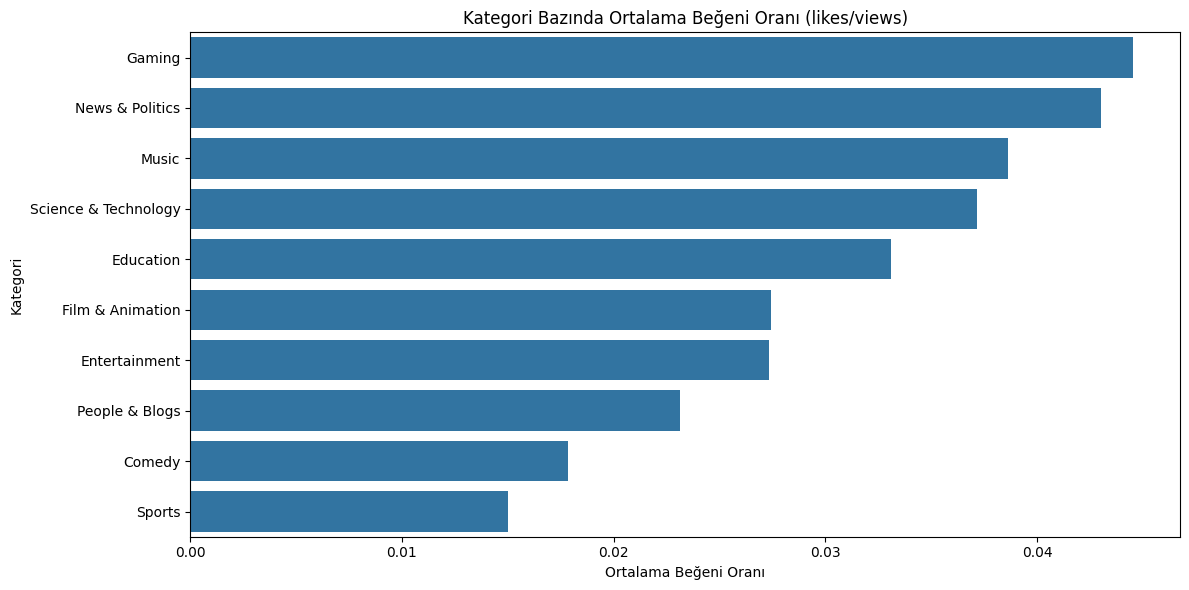

In [36]:
df_videos['like_ratio'] = df_videos['likes'] / df_videos['views']
like_ratio_by_category = df_videos.groupby('category_name')['like_ratio'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=like_ratio_by_category.values, y=like_ratio_by_category.index)
plt.title("Kategori Bazında Ortalama Beğeni Oranı (likes/views)")
plt.xlabel("Ortalama Beğeni Oranı")
plt.ylabel("Kategori")
plt.tight_layout()
plt.show()

## 🔟 En Çok İzlenen 10 Trend Video (Detaylı Tablo)

Bu tabloda, analiz edilen dönemde Türkiye'de YouTube trendlerine giren **en yüksek izlenme sayısına sahip 10 video** listelenmiştir.


In [37]:
top_videos = df_videos.sort_values(by='views', ascending=False).head(10)
top_videos[['title', 'channel', 'category_name', 'views', 'likes', 'published_at']]

,title,channel,category_name,views,likes,published_at
45,"Lose 100 LBs, Win $250,000!",MrBeast,Entertainment,142322566,5369865,2025-06-21 16:00:01+00:00
1,Which Shoes Will Protect Your Feet?,Ben Azelart,Entertainment,82799295,2089067,2025-06-24 21:50:02+00:00
46,SQUID GAME HOUSE vs GUARDS 🏠🦑🥷,A4,Entertainment,81499729,2773819,2025-06-21 14:05:16+00:00
3,"If You Spill, You Lose!",MrBeast,Entertainment,74126693,1830445,2025-06-25 17:00:08+00:00
33,Can Starbucks spell brainrots’ names right?,The Richey Family,People & Blogs,73456796,1538794,2025-06-21 15:01:43+00:00
51,Can We Sneak Our Dog Into the Restaurant in a ...,The Richey Family,People & Blogs,62975427,1340753,2025-06-18 15:02:49+00:00
76,Unusual Ballerina Cappuccina #shorts #YuliaBely,Yuliash Belyash,Entertainment,34012125,695917,2025-06-18 13:45:02+00:00
36,Remote control car #builderc,Construction Site,Entertainment,34008889,415189,2025-06-24 10:15:04+00:00
42,Chocolate Peeling Game🍫,ISSEI / いっせい,Entertainment,32026935,988196,2025-06-22 10:01:34+00:00
18,Bất ngờ chưa hai [BEN EAGLE] #beneagle #kungfu...,BEN EAGLE,Entertainment,28003994,362185,2025-06-25 13:01:15+00:00


## 👍 Beğeni Oranına Göre İlk 10 Video (likes/views)

Bu tabloda, **beğeni oranı (like-to-view ratio)** en yüksek olan ilk 10 video yer almaktadır.

Beğeni oranı, bir videonun toplam izlenme sayısına göre ne kadar beğeni aldığını gösteren önemli bir etkileşim metriğidir. Bu metrik, izleyici memnuniyetinin ve içeriğin kalitesinin bir göstergesi olarak değerlendirilebilir.

Bu analiz sayesinde kullanıcıların en çok etkileşim kurduğu ve beğendiği içerikler daha net şekilde anlaşılabilir.


In [38]:
df_videos["like_ratio"] = df_videos["likes"] / df_videos["views"]

In [39]:
df_videos.sort_values("like_ratio", ascending=False).head(10)

,title,channel,category_id,views,likes,comments,published_at,category_name,like_ratio
50,Who’s Next? 🏃🏿💨 #ishowspeed,IShowSpeed,20,17829726,1409630,26114,2025-06-23 18:39:37+00:00,Gaming,0.079061
10,YOUTUBE 'U BIRAKIYORUM.,Ahmet Can Dündar,24,1120745,76480,32204,2025-06-27 16:01:30+00:00,Entertainment,0.068240
12,24 SAAT KREDİ KARTLARINI DEĞİŞTİRDİK !? Feride...,Feride Özdinç,24,580618,35665,3197,2025-06-28 09:01:20+00:00,Entertainment,0.061426
8,BODRUM VLOG w/ @blok3real.,İbrahim Tilaver,24,509616,31045,1031,2025-06-28 15:00:22+00:00,Entertainment,0.060918
16,Gamze Karta & Uzunmakarna - Geçmişe Dair,netd müzik,10,335692,18527,16515,2025-06-28 12:00:07+00:00,Music,0.055190
6,Norm Ender X Ebru Gündeş - Bir Çift Göz,Norm Ender,10,2348024,121112,6813,2025-06-26 22:15:07+00:00,Music,0.051580
20,KURTLARLA VAHŞİ HAYVAN İZİ SÜRDÜK! @doganayvural,Deli Mi Ne?,22,533338,27037,969,2025-06-27 17:00:04+00:00,People & Blogs,0.050694
14,ŞANS ESERİ ÜNLENEN TÜRK KÖPEK..???,CharmQuell,20,436345,21359,351,2025-06-27 17:33:11+00:00,Gaming,0.048950
15,How To Fool Your Brain!,Mark Rober,28,6611400,311411,1357,2025-06-27 15:30:20+00:00,Science & Technology,0.047102
13,Sizden daha iyi bir futbolcu?,uberkuloz,24,3135448,146776,1558,2025-06-24 16:26:01+00:00,Entertainment,0.046812


## 📅 Yayın Gününe Göre Ortalama İzlenme Sayısı

Bu tabloda videoların haftanın hangi günü yayınlandığına göre **ortalama izlenme sayıları** karşılaştırılmıştır.

Elde edilen bulgular, kullanıcı davranışlarına dair önemli ipuçları verebilir:

- Hangi günlerde içerik paylaşmak daha fazla izlenmeye yol açıyor?
- Trend videolar en çok hangi günlerde öne çıkıyor?

İçerik stratejisi oluştururken bu analiz, yayın zamanlaması açısından faydalı bir referans olabilir.

In [45]:
df_videos["published_day"] = df_videos["published_at"].dt.day_name()
df_videos.groupby("published_day")["views"].mean().sort_values(ascending=False)

,views
published_day,
Saturday,2.200556e+07
Tuesday,1.698117e+07
Wednesday,1.560163e+07
Monday,1.054954e+07
Sunday,7.287076e+06
Friday,5.221995e+06
Thursday,2.537869e+06


## 💬 Yorum Oranına Göre En Yüksek Etkileşim Alan Videolar

Bu tabloda videoların **izlenme başına aldığı yorum sayısı** (`comment_ratio`) hesaplanmış ve en yüksek oranlara sahip 10 video sıralanmıştır.

Yorum oranı (comments/views), bir videonun izleyiciyi ne kadar **sohbet, tartışma veya geri bildirim vermeye teşvik ettiğini** gösteren önemli bir etkileşim metriğidir.

 Özellikle tartışmalı konular, toplumsal meseleler veya eğitim içerikleri bu listede ön plana çıkmıştır.

In [51]:
df_videos["comment_ratio"] = df_videos["comments"] / df_videos["views"]
df_videos.sort_values("comment_ratio", ascending=False)[["title", "channel", "comment_ratio"]].head(10)

,title,channel,comment_ratio
16,Gamze Karta & Uzunmakarna - Geçmişe Dair,netd müzik,0.049197
10,YOUTUBE 'U BIRAKIYORUM.,Ahmet Can Dündar,0.028734
73,TYT Türkçe 2025 Sorular ve Cevaplar,Rüştü Hoca ile Türkçe,0.007472
78,AYT Edebiyat Son Tekrar,Rüştü Hoca ile Türkçe,0.006826
26,muhtar bile olamaz,140journos,0.005642
12,24 SAAT KREDİ KARTLARINI DEĞİŞTİRDİK !? Feride...,Feride Özdinç,0.005506
54,24 SAAT HAMAKTA YAŞAMAK !? | Sıla Dündar Ferid...,Sıla Dündar,0.004067
67,"Tokat’ta bir pazarcı, kendi bahçesinde yetişti...",Genç Motto,0.002954
6,Norm Ender X Ebru Gündeş - Bir Çift Göz,Norm Ender,0.002902
70,TYT 2025 Yorumum ⚡️Cevaplara Bakmaaa👀,Gri Koç,0.002720
